# Cricket Match Prediction with Brownian Motion 🏏

This notebook demonstrates how to model a cricket team's scoring progression using stochastic processes, specifically **Simple Brownian Motion (SBM)** and **Geometric Brownian Motion (GBM)**. These models, originating from financial mathematics, can help us simulate potential score outcomes and estimate win probabilities by incorporating uncertainty.

We'll use a hypothetical T20 chase scenario:
* **Target:** 181 runs
* **Overs:** 20 (120 balls)
* **Chasing Team:** We will simulate their innings.

The core idea is to model the score not just as a straight line based on an average run rate, but as a random walk that drifts towards an average, accounting for the natural variance in scoring (e.g., a mix of dot balls, singles, and boundaries).

--- 
## 1. Simple Brownian Motion (SBM)

Simple Brownian Motion is defined by the stochastic differential equation (SDE):
$$dS_t = \mu dt + \sigma dW_t$$
Where:
* $S_t$ is the value of the process at time $t$ (we'll model the team's score).
* $\mu$ (mu) is the **drift**, representing the average rate of change (average runs per ball).
* $\sigma$ (sigma) is the **volatility**, representing the standard deviation or randomness (how much the scoring deviates from the average).
* $dW_t$ is the Wiener process or Brownian motion term, which introduces randomness.

Let's simulate the run chase using SBM.

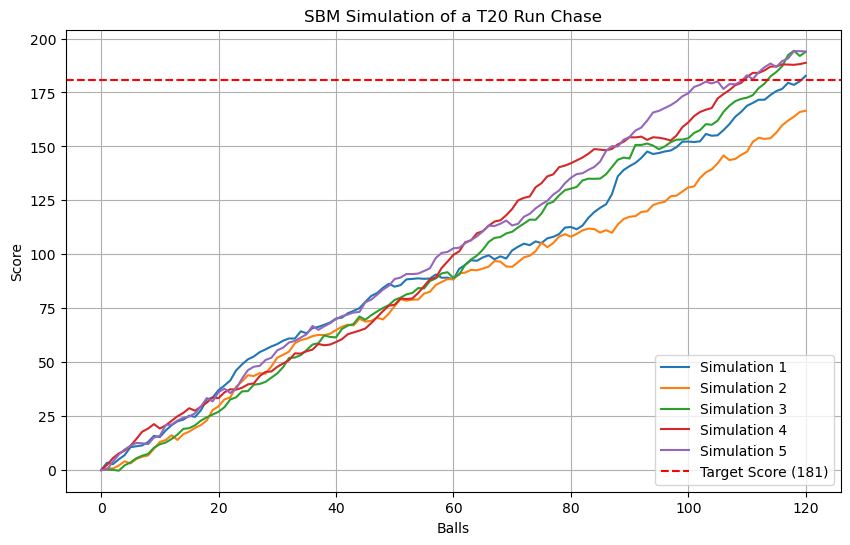

SBM Simulation Results:
Average Predicted Final Score: 180.24
Predicted Win Probability: 49.60%


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- Simulation Parameters ---
target = 181
balls = 120
simulations = 1000 # Number of times we simulate the innings

# SBM Parameters
# We need 181 runs in 120 balls.
mu = target / balls  # Drift (average runs required per ball)
sigma = 1.5          # Volatility (assumed standard deviation of runs per ball)
S0 = 0               # Initial score

# --- Simulation ---
# Time step is 1 ball
dt = 1
# Create an array to hold the final scores of all simulations
final_scores_sbm = np.zeros(simulations)

plt.figure(figsize=(10, 6))

for i in range(simulations):
    S = np.zeros(balls + 1)
    S[0] = S0
    for t in range(1, balls + 1):
        # The SBM formula in discrete time
        # S(t) = S(t-1) + mu*dt + sigma*sqrt(dt)*Z
        # where Z is a random number from a standard normal distribution
        S[t] = S[t-1] + mu * dt + sigma * np.sqrt(dt) * np.random.normal(0, 1)
    
    final_scores_sbm[i] = S[-1]
    
    # Plot first 5 simulations for visualization
    if i < 5:
        plt.plot(S, label=f'Simulation {i+1}')

# --- Visualization & Analysis ---
# Plot a line representing the target
plt.axhline(y=target, color='r', linestyle='--', label='Target Score (181)')
plt.title('SBM Simulation of a T20 Run Chase')
plt.xlabel('Balls')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

# Calculate win probability
wins_sbm = np.sum(final_scores_sbm >= target)
win_prob_sbm = wins_sbm / simulations

print(f"SBM Simulation Results:")
print(f"Average Predicted Final Score: {np.mean(final_scores_sbm):.2f}")
print(f"Predicted Win Probability: {win_prob_sbm:.2%}")

### Analysis of SBM
SBM is a start, but it has a major flaw for modeling scores: **it can produce negative values**. A team's score can't be less than zero. This limitation makes SBM conceptually weak for this specific problem, although it introduces the core concepts of drift and volatility.

---

## 2. Geometric Brownian Motion (GBM)

Geometric Brownian Motion is often a better model for quantities that cannot be negative, like stock prices or, in our case, cricket scores. Its SDE is:
$$dS_t = \mu S_t dt + \sigma S_t dW_t$$
Notice the key difference: the drift and volatility terms are now proportional to the current score $S_t$. This means the change in score is a percentage of the current score, leading to multiplicative or exponential growth, which is more intuitive for a progressing innings.

The solution to the GBM SDE, which we use for simulation, is:
$$S_t = S_0 \exp\left( \left(\mu - \frac{\sigma^2}{2}\right)t + \sigma W_t \right)$$

Let's apply this more realistic model.

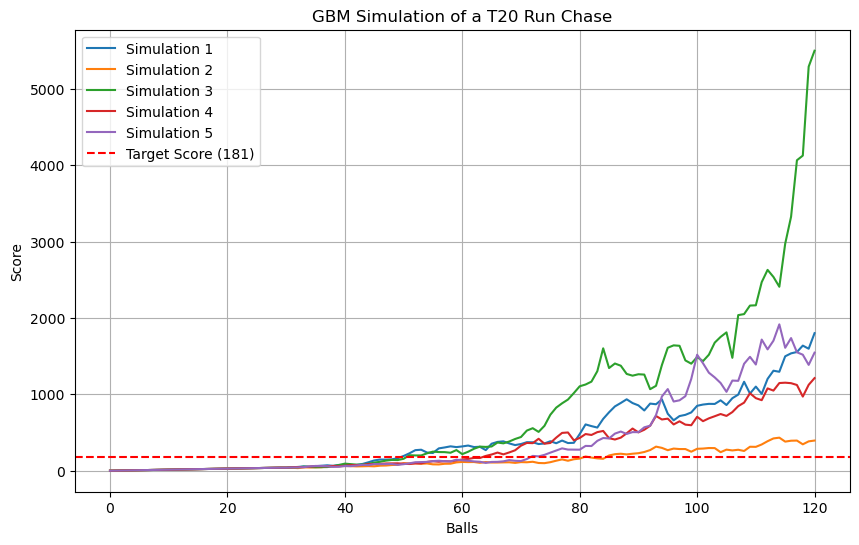


GBM Simulation Results:
Average Predicted Final Score: 1332.33
Predicted Win Probability: 95.00%


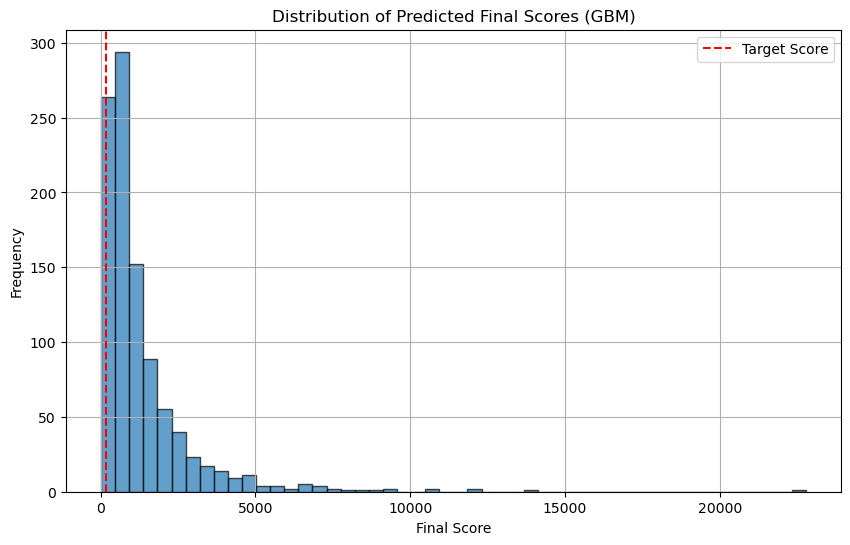

In [2]:
# --- Simulation Parameters ---
# Let's assume the chasing team is 40/0 after 5 overs (30 balls).
# We need to simulate the remaining 90 balls.
S0_gbm = 40          # Initial score after 30 balls
balls_remaining = 90
target_remaining = target - S0_gbm

# GBM Parameters
# Drift (mu) is the expected % increase in score per ball
# We need target_remaining / S0_gbm growth over 90 balls
mu_gbm = (target_remaining / S0_gbm) / balls_remaining 
sigma_gbm = 0.1      # Volatility as a percentage (e.g., 10% variance per ball)
simulations = 1000

# --- Simulation ---
dt_gbm = 1
final_scores_gbm = np.zeros(simulations)

plt.figure(figsize=(10, 6))

for i in range(simulations):
    S_gbm = np.zeros(balls_remaining + 1)
    S_gbm[0] = S0_gbm
    for t in range(1, balls_remaining + 1):
        # The GBM formula in discrete time
        # S(t) = S(t-1) * exp((mu - 0.5*sigma^2)*dt + sigma*sqrt(dt)*Z)
        Z = np.random.normal(0, 1)
        S_gbm[t] = S_gbm[t-1] * np.exp((mu_gbm - 0.5 * sigma_gbm**2) * dt_gbm + sigma_gbm * np.sqrt(dt_gbm) * Z)
    
    final_scores_gbm[i] = S_gbm[-1]
    
    # Plot first 5 simulations
    if i < 5:
        # We plot the full innings score by combining the initial 40 with the simulation
        full_innings_path = np.concatenate([np.linspace(0, S0_gbm, 30), S_gbm])
        ball_axis = np.arange(0, 121)
        plt.plot(ball_axis, full_innings_path, label=f'Simulation {i+1}')

# --- Visualization & Analysis ---
plt.axhline(y=target, color='r', linestyle='--', label='Target Score (181)')
plt.title('GBM Simulation of a T20 Run Chase')
plt.xlabel('Balls')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

# Calculate win probability
wins_gbm = np.sum(final_scores_gbm >= target)
win_prob_gbm = wins_gbm / simulations

print(f"\nGBM Simulation Results:")
print(f"Average Predicted Final Score: {np.mean(final_scores_gbm):.2f}")
print(f"Predicted Win Probability: {win_prob_gbm:.2%}")

# Plot the distribution of final scores
plt.figure(figsize=(10, 6))
plt.hist(final_scores_gbm, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=target, color='r', linestyle='--', label='Target Score')
plt.title('Distribution of Predicted Final Scores (GBM)')
plt.xlabel('Final Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

## Conclusion 📊

This exercise shows how stochastic processes can frame cricket predictions in terms of probabilities rather than deterministic outcomes.

* **Simple Brownian Motion (SBM)** is a basic introduction but is flawed because it allows for negative scores.
* **Geometric Brownian Motion (GBM)** is a much better fit. Its multiplicative nature ensures scores are always positive and captures the compounding effect of a good or bad run of play.

The real power of this approach would come from accurately **estimating $\mu$ and $\sigma$ from historical data** for specific teams and players against different opponents, making the simulation a powerful predictive tool.